## 1) Imports & Tham số chính

- **Import thư viện cần thiết**:
  - `numpy`, `pandas` để xử lý dữ liệu số và bảng.
  - `matplotlib` để vẽ biểu đồ.
  - `sklearn` (KMeans, StandardScaler, MinMaxScaler) để chuẩn hóa dữ liệu & phân cụm.
  - `getpass` để nhập mật khẩu an toàn (không hiện ra màn hình).
  - `FiinSession` từ `FiinQuantX` để kết nối API FiinQuant.

- **Khai báo tham số cấu hình (parameters)**:
  - `INDEX = "VN30"`: rổ cổ phiếu VN30 là universe nghiên cứu.
  - `BENCH = "VNINDEX"`: dùng VNINDEX làm benchmark để so sánh hiệu quả.
  - `LOOKBACK_DAYS = 540`: số ngày dữ liệu lịch sử để backtest.
  - `VP_BINS = 30`: số bins để chia khung giá khi tính Volume Profile.
  - `INITIAL_CAPITAL = 1_000_000`: vốn khởi đầu backtest.
  - `STOPLOSS_PCT = -0.12`: cắt lỗ 12%.
  - `TAKEPROFIT_PCT = 0.30`: chốt lời 30%.
  - `TOP_K = 3`: mỗi lần rebalance chọn 3 cổ phiếu có score cao nhất.
  - Các tham số khác như `COMMISSION_PCT`, `SLIPPAGE_PCT` để mô phỏng phí giao dịch và trượt giá.

👉 Tóm lại, cell này giúp chuẩn bị “công cụ” và “luật chơi” cho toàn bộ backtest.


In [ ]:
!pip install datetime numpy pandas matplotlib sklearn 
!pip install pip install --extra-index-url https://fiinquant.github.io/fiinquantx/simple fiinquantx

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# FiinQuant client
from FiinQuantX import FiinSession

# ---------------------------
# Parameters (tune as you like)
# ---------------------------
INDEX = "VN30"
BENCH = "VNINDEX"
BY = "1d"
LOOKBACK_DAYS = 540
VP_BINS = 30
CLUSTER_WINDOW = 60
INITIAL_CAPITAL = 1_000_000
STOPLOSS_PCT = -0.12
TAKEPROFIT_PCT = 0.30
MAX_SIDEWAY_ALLOC = 0.30
HOLD_MAX_DAYS = 60

COMMISSION_PCT = 0.0005   # 0.05% per trade
SLIPPAGE_PCT = 0.0005     # 0.05% slippage
TOP_K = 3                 # trade top 3 every rebalance
MIN_VOLUME_MEDIAN = 0     # allow > 0 means require positive volume

## 2) Login vào FiinQuant API

- **Mục đích:** xác thực để gọi dữ liệu.
- **Tại sao:** nhiều hàm yêu cầu session hợp lệ.
- **Cách làm:** nhập username/password, mật khẩu dùng `getpass` để ẩn.

👉 Nếu login thất bại, dừng notebook.


In [2]:
USERNAME = "DSTC_18@fiinquant.vn"
PASSWORD = "Fiinquant0606"
client = FiinSession(username=USERNAME, password=PASSWORD).login()
if client is None:
    raise RuntimeError("Login failed.")
print("Logged in:", USERNAME)


Logged in: DSTC_18@fiinquant.vn


## 3) Các hàm phụ trợ

- `to_list_safe`: chuyển input thành list an toàn.
- `safe_get_datecol`: lấy cột ngày trong DataFrame (nhiều dạng khác nhau).
- `compute_vp_for_window`: tính Volume Profile (POC + HVN).
  - **POC**: giá có khối lượng giao dịch tích lũy lớn nhất.
  - **HVN**: vùng giá có thanh khoản cao.

👉 Các hàm này sẽ dùng xuyên suốt notebook.


In [3]:
def to_list_safe(x):
    try:
        return list(x)
    except Exception:
        return x if isinstance(x, list) else [x]

def safe_get_datecol(df):
    if 'timestamp' in df.columns:
        return pd.to_datetime(df['timestamp'])
    if 'TradingDate' in df.columns:
        return pd.to_datetime(df['TradingDate'])
    if 'date' in df.columns:
        return pd.to_datetime(df['date'])
    return pd.to_datetime(df.index)

def compute_vp_for_window(prices, volumes, bins=VP_BINS):
    if len(prices)==0 or np.nansum(volumes)==0:
        return (np.nan, np.nan, np.nan)
    hist, edges = np.histogram(prices, bins=bins, weights=volumes)
    idx = int(np.nanargmax(hist))
    poc = (edges[idx] + edges[idx+1]) / 2.0
    return poc, edges[idx], edges[idx+1]


## 4) Lấy danh sách ticker & dữ liệu lịch sử

- `client.TickerList("VN30")`: trả về danh sách cổ phiếu VN30.
- `Fetch_Trading_Data`: lấy dữ liệu OHLCV + các trường bổ sung (`bu, sd, fn`).
- Chuẩn hóa cột ngày, convert numeric, thêm `trading_value = close * volume`.

👉 Đây là dữ liệu đầu vào để tính chỉ báo & chạy backtest.


In [4]:
tickers = to_list_safe(client.TickerList(ticker=INDEX))
if BENCH not in tickers:
    all_tickers = tickers + [BENCH]
else:
    all_tickers = tickers.copy()
print(f"Tickers count: {len(tickers)}")

from_date = (datetime.now() - timedelta(days=LOOKBACK_DAYS)).strftime("%Y-%m-%d")
fields = ['open','high','low','close','volume','bu','sd','fn']   # valid fields

evt = client.Fetch_Trading_Data(
    realtime=False,
    tickers=all_tickers,
    fields=fields,
    adjusted=True,
    by=BY,
    from_date=from_date
)
raw = evt.get_data()
df = pd.DataFrame(raw)
if df.empty:
    raise RuntimeError("No data returned from Fetch_Trading_Data()")

df['date'] = safe_get_datecol(df)
df.sort_values(['ticker','date'], inplace=True)
df.reset_index(drop=True, inplace=True)

# numeric
for c in ['open','high','low','close','volume','bu','sd','fn']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# compute trading_value
df['trading_value'] = df['close'] * df['volume']

Tickers count: 30
Fetching data, it may take a while. Please wait...


## 5) Chỉ báo kỹ thuật

- **Mục tiêu:** tính các feature TA:
  - RSI (14), MACD histogram.
  - ATR14: đo biến động.
  - Bollinger width: độ rộng biên Bollinger.
  - EMA20, EMA50: xu hướng ngắn hạn.

- **Cách tính:**
  - Ưu tiên dùng hàm trong `FiinIndicator()`.
  - Nếu lỗi thì fallback sang pandas.

👉 Kết quả thêm các cột chỉ báo vào DataFrame.


In [5]:
fi = client.FiinIndicator()

def add_indicators(g):
    g = g.sort_values('date').copy()
    try:
        g['rsi'] = fi.rsi(g['close'], window=14)
    except Exception:
        delta = g['close'].diff()
        up = delta.clip(lower=0).ewm(alpha=1/14).mean()
        down = -delta.clip(upper=0).ewm(alpha=1/14).mean()
        rs = up / down
        g['rsi'] = 100 - 100/(1+rs)
    try:
        g['macd_hist'] = fi.macd_diff(g['close'])
    except Exception:
        ema12 = g['close'].ewm(span=12).mean(); ema26 = g['close'].ewm(span=26).mean()
        macd = ema12 - ema26; sig = macd.ewm(span=9).mean()
        g['macd_hist'] = macd - sig
    # ATR14
    g['tr1'] = g['high'] - g['low']
    g['tr2'] = (g['high'] - g['close'].shift()).abs()
    g['tr3'] = (g['low'] - g['close'].shift()).abs()
    g['true_range'] = g[['tr1','tr2','tr3']].max(axis=1)
    g['atr14'] = g['true_range'].rolling(14, min_periods=1).mean()
    # Bollinger width
    g['bb_mid'] = g['close'].rolling(20, min_periods=1).mean()
    g['bb_std'] = g['close'].rolling(20, min_periods=1).std()
    g['bb_width'] = (4 * g['bb_std']) / g['bb_mid']
    # EMA20, EMA50 (fast trend)
    try:
        g['ema20'] = fi.ema(g['close'], window=20)
        g['ema50'] = fi.ema(g['close'], window=50)
    except Exception:
        g['ema20'] = g['close'].ewm(span=20).mean()
        g['ema50'] = g['close'].ewm(span=50).mean()
    return g

df = df.groupby('ticker', group_keys=False).apply(add_indicators).reset_index(drop=True)


## 6) Volume Profile (POC/HVN)

- Tính POC/HVN cho từng cổ phiếu trên toàn bộ lịch sử.
- **Ý nghĩa:**
  - Giá vượt HVN_high → breakout volume.
  - POC: giá được coi là vùng cân bằng.

👉 Feature này bổ sung vào scoring sau.


In [6]:
vp_list = []
for t in all_tickers:
    g = df[df['ticker']==t]
    poc, hvn_low, hvn_high = compute_vp_for_window(g['close'].values, g['volume'].values, bins=VP_BINS)
    vp_list.append({'ticker':t,'POC':poc,'HVN_low':hvn_low,'HVN_high':hvn_high})
vp_df = pd.DataFrame(vp_list)

## 7) Market regime (Offense / Sideway / Defense)

- **Dữ liệu:** tổng hợp từ VN30.
  - Trung bình close, tổng giá trị giao dịch, ATR14, Bollinger width.
- **Phân cụm:** KMeans sliding window.
  - Chia 3 chế độ:
    - Offense: thị trường thuận lợi.
    - Sideway: đi ngang.
    - Defense: thị trường xấu.
- **Fallback:** nếu KMeans lỗi → dùng percentile.

👉 Regime quyết định tỷ trọng phân bổ vốn trong backtest.


In [7]:
vn30_df = df[df['ticker'].isin(tickers)].copy()
mkt = vn30_df.groupby('date').agg({
    'close':'mean',
    'trading_value':'sum',
    'fn':'sum'
}).rename(columns={'close':'vn30_close','trading_value':'vn30_val','fn':'vn30_fn'}).reset_index()

mkt['vn30_tr'] = mkt['vn30_close'].diff().abs()
mkt['vn30_atr14'] = mkt['vn30_tr'].rolling(14, min_periods=1).mean()
mkt['vn30_bb_mid'] = mkt['vn30_close'].rolling(20, min_periods=1).mean()
mkt['vn30_bb_std'] = mkt['vn30_close'].rolling(20, min_periods=1).std()
mkt['vn30_bb_width'] = (4 * mkt['vn30_bb_std']) / mkt['vn30_bb_mid']
mkt = mkt.dropna(subset=['vn30_val','vn30_fn','vn30_atr14','vn30_bb_width']).reset_index(drop=True)

def compute_regime_series_robust(mkt_df, window=CLUSTER_WINDOW):
    mkt_df = mkt_df.sort_values('date').reset_index(drop=True)
    rows=[]
    for i in range(window, len(mkt_df)+1):
        win = mkt_df.iloc[i-window:i]
        X = win[['vn30_val','vn30_atr14','vn30_bb_width','vn30_fn']].fillna(0).values
        scaler = StandardScaler()
        Xz = scaler.fit_transform(X)
        # try KMeans with n_init=1 to avoid joblib parallelization
        try:
            k = KMeans(n_clusters=3, random_state=42, n_init=1, max_iter=300).fit(Xz)
            centers = k.cluster_centers_
            scores = centers.sum(axis=1)
            order = np.argsort(scores)[::-1]  # highest -> Offense
            map_cluster = {order[0]:'Offense', order[1]:'Sideway', order[2]:'Defense'}
            label = map_cluster[int(k.labels_[-1])]
        except Exception as e:
            # Fallback: avoid KMeans entirely: use last-row combined z-score percentile
            # compute z-score of last row over window (sum of z per feature)
            zz = (Xz[-1,:]).sum()
            # compare zz to distribution of sum-of-z across window
            sums = Xz.sum(axis=1)
            p = (sums < sums[-1]).mean()
            # percentiles split into tertiles
            if p >= 2/3:
                label = 'Offense'
            elif p >= 1/3:
                label = 'Sideway'
            else:
                label = 'Defense'
        rows.append({'date': win['date'].iloc[-1], 'regime': label})
    return pd.DataFrame(rows)

regime_df = compute_regime_series_robust(mkt, window=CLUSTER_WINDOW)
mkt = mkt.merge(regime_df, on='date', how='left')
regime_map = mkt.set_index('date')['regime'].to_dict()
regime_dates = sorted(regime_map.keys())
def get_regime_for_date(date):
    if date in regime_map:
        return regime_map[date]
    earlier = [d for d in regime_dates if d <= date]
    return regime_map[earlier[-1]] if earlier else 'Defense'

print("Regime detection ready.")

  File "c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Regime detection ready.


## 8) Fundamentals (FA)

- Dùng `FundamentalAnalysis().get_ratios` để lấy:
  - ROE (hiệu quả sinh lời).
  - PE (định giá).
  - DebtToEquity (đòn bẩy).
  - OCF (dòng tiền từ HĐKD).
- Chuẩn hóa tên cột về `ROE, PE, DebtToEquity, OCF`.

👉 Thông tin FA giúp scoring thêm chiều cơ bản (FA + TA).


In [8]:
fa = client.FundamentalAnalysis()
fa_raw = fa.get_ratios(
    tickers=tickers,
    TimeFilter="Quarterly",
    LatestYear=2024,
    NumberOfPeriod=4,
    Consolidated=True,
    Fields=["ProfitabilityRatio.ROE","ValuationRatio.PE","LeverageRatio.DebtToEquity","CashFlowRatio.OCF"]
)
# normalize
if isinstance(fa_raw, dict):
    fa_df = pd.DataFrame.from_dict(fa_raw, orient='index').reset_index().rename(columns={'index':'ticker'})
elif isinstance(fa_raw, list):
    fa_df = pd.DataFrame(fa_raw)
else:
    fa_df = pd.DataFrame([fa_raw])
# map column names if necessary
col_map = {}
for col in fa_df.columns:
    lc = col.lower()
    if 'roe' in lc: col_map[col] = 'ROE'
    if '.pe' in lc or 'valuation' in lc and 'pe' in lc: col_map[col] = 'PE'
    if 'debt' in lc and 'equity' in lc: col_map[col] = 'DebtToEquity'
    if 'ocf' in lc: col_map[col] = 'OCF'
fa_df.rename(columns=col_map, inplace=True)
for c in ['ROE','PE','DebtToEquity','OCF']:
    if c not in fa_df.columns:
        fa_df[c] = np.nan
fa_df = fa_df[['ticker','ROE','PE','DebtToEquity','OCF']].drop_duplicates(subset=['ticker'], keep='last')


## 9) Hàm scoring

- Input: snapshot dữ liệu (tới ngày `d`).
- Các bước:
  - Tính feature TA + FA + VP + liquidity.
  - Normalize (MinMaxScaler).
  - Cộng điểm theo trọng số:
    - RSI, MACD, breakout, ROE, OCF (tích cực).
    - PE, DebtToEquity (tiêu cực).
- Output: DataFrame gồm ticker, score, và các feature.

👉 Đây là “trái tim” của chiến lược.


In [9]:
def score_universe_on_date(date, df_all, vp_df, fa_df, tickers):
    # gather latest row per ticker at or before date
    rows=[]
    for t in tickers:
        hist = df_all[(df_all['ticker']==t) & (df_all['date']<=date)].sort_values('date')
        if hist.empty:
            continue
        row = hist.iloc[-1].copy()
        # 20-day median volume up to date
        vol20 = df_all[(df_all['ticker']==t) & (df_all['date']<=date)].tail(20)['volume']
        row['vol20_med'] = vol20.median() if not vol20.empty else 0
        # vp last 120 days
        h = df_all[(df_all['ticker']==t) & (df_all['date']<=date)].tail(120)
        poc, hvn_low, hvn_high = compute_vp_for_window(h['close'].values, h['volume'].values, bins=VP_BINS)
        row['POC'], row['HVN_low'], row['HVN_high'] = poc, hvn_low, hvn_high
        # fundamentals
        fa_row = fa_df[fa_df['ticker']==t]
        if not fa_row.empty:
            for c in ['ROE','PE','DebtToEquity','OCF']:
                row[c] = fa_row.iloc[0].get(c, np.nan)
        else:
            row['ROE']=row['PE']=row['DebtToEquity']=row['OCF']=np.nan
        rows.append(row)
    if not rows:
        return pd.DataFrame()
    snap = pd.DataFrame(rows)
    # create TA features and signals
    snap['vp_breakout'] = snap.apply(lambda r: 1 if (not np.isnan(r['HVN_high']) and r['close']>r['HVN_high']) else 0, axis=1)
    snap['vol_ratio'] = snap['volume'] / (snap['vol20_med'].replace(0,np.nan))
    snap['mom20'] = snap.groupby('ticker')['close'].transform(lambda x: x.pct_change(20)).fillna(0)  # but here only last value; keep as zero fallback
    # For scoring we need numeric features: rsi, macd_hist, vol_ratio, vp_breakout, ROE, PE (inverted), DebtToEquity (inverted), OCF (positive)
    feature_cols = []
    # ensure numeric
    for c in ['rsi','macd_hist','vol_ratio','vp_breakout','ROE','PE','DebtToEquity','OCF']:
        if c not in snap.columns:
            snap[c]=0
        feature_cols.append(c)
    # cleanup infinite
    snap.replace([np.inf, -np.inf], np.nan, inplace=True)
    snap.fillna(0, inplace=True)
    # Normalize features across universe (MinMax)
    mm = MinMaxScaler()
    X = mm.fit_transform(snap[feature_cols].values)
    Xdf = pd.DataFrame(X, columns=[f"norm_{c}" for c in feature_cols], index=snap.index)
    snap = pd.concat([snap.reset_index(drop=True), Xdf.reset_index(drop=True)], axis=1)
    # weights (tweakable)
    weights = {
        'rsi':0.18,
        'macd_hist':0.18,
        'vol_ratio':0.12,
        'vp_breakout':0.18,
        'ROE':0.12,
        'PE':-0.05,           # lower PE better -> negative weight
        'DebtToEquity':-0.07,# lower debt better
        'OCF':0.12
    }
    # compute score = sum(weights * normalized_feature)
    score = np.zeros(len(snap))
    for feat,w in weights.items():
        score += w * snap[f"norm_{feat}"].values
    # normalize score to 0..1
    smin,smax = score.min(), score.max()
    if smax - smin > 1e-9:
        score_norm = (score - smin)/(smax - smin)
    else:
        score_norm = np.zeros_like(score)
    snap['score'] = score_norm
    snap['date_scored'] = date
    # keep only needed columns
    return snap[['ticker','date_scored','close','rsi','macd_hist','volume','vol_ratio','vp_breakout','ROE','PE','DebtToEquity','OCF','score','HVN_high','POC']]


## 10) Backtest logic

- Mỗi ngày:
  1. Tính snapshot, chọn `TOP_K` tickers.
  2. Regime quyết định allocation:
     - Offense → full.
     - Sideway → giảm.
     - Defense → có thể short VNINDEX.
  3. Quản lý vị thế:
     - Entry khi vào TOP_K.
     - Exit nếu stoploss, takeprofit, out_of_topk, hoặc RSI quá cao.

- Ghi lại NAV (giá trị danh mục) và trades.

👉 Kết quả: lịch sử danh mục + danh sách giao dịch.


In [10]:
# prepare bench & universe date index
bench_series = df[df['ticker']==BENCH].sort_values('date').set_index('date')['close']
# Choose backtest dates: intersection of market regime dates and bench (use mkt/regime dates)
backtest_dates = sorted(set(df['date'].unique()).intersection(set(bench_series.index)))
backtest_dates = [d for d in backtest_dates if d >= min(regime_dates)]  # ensure regime available

capital = INITIAL_CAPITAL
cash = capital
positions = {}   # key ticker -> position dict
trades = []      # list of trade dicts
nav = []

for today in backtest_dates:
    regime = get_regime_for_date(today)
    # compute scores snapshot for this date
    snapshot = score_universe_on_date(today, df, vp_df, fa_df, tickers)
    if snapshot.empty:
        nav.append({'date':today,'nav':cash + sum([p['size']*p['mark_price'] for p in positions.values()])})
        continue
    # pick top_k by score
    snapshot.sort_values('score', ascending=False, inplace=True)
    topk = snapshot.head(TOP_K)
    topk_tickers = topk['ticker'].tolist()
    # decide allocation multiplier by regime
    if regime == 'Offense':
        regime_mult = 1.0
    elif regime == 'Sideway':
        regime_mult = MAX_SIDEWAY_ALLOC
    else:
        regime_mult = 0.0
    # If Defense: open/maintain short on bench (if none open)
    # For simplicity keep bench short as single position type 'short_bench'
    bench_price = bench_series.loc[today]
    # manage bench short
    if regime == 'Defense':
        if 'SHORT_BENCH' not in positions:
            notional = capital * 1.0
            entry_price = bench_price * (1 + SLIPPAGE_PCT)
            size = notional / entry_price
            commission = notional * COMMISSION_PCT
            cash += size * entry_price - commission   # receive proceeds
            positions['SHORT_BENCH'] = {'side':'short','ticker':BENCH,'entry_date':today,'entry_price':entry_price,'size':size,'stop':entry_price*(1 - STOPLOSS_PCT),'tp':entry_price*(1 - TAKEPROFIT_PCT),'commission':commission,'mark_price':entry_price}
            trades.append({'type':'short','ticker':BENCH,'entry_date':today,'entry_price':entry_price,'size':size,'commission':commission})
    else:
        # if regime not Defense and bench short exists -> close it
        if 'SHORT_BENCH' in positions:
            pos = positions.pop('SHORT_BENCH')
            exit_price = bench_price * (1 - SLIPPAGE_PCT)
            commission = pos['size'] * exit_price * COMMISSION_PCT
            cash -= pos['size'] * exit_price + commission
            trades.append({'type':'short_exit','ticker':BENCH,'exit_date':today,'exit_price':exit_price,'size':pos['size'],'commission':commission})
    # Manage existing equity positions:
    #  - exit if stop/tp/hard_time or if not in top_k anymore (rebalancing daily)
    #  - For remaining positions that are still in top_k, update mark price
    # first update marks & check exits
    to_remove=[]
    for t, pos in positions.copy().items():
        if pos['side']!='long': continue
        # find today's price for ticker
        srow = df[(df['ticker']==t)&(df['date']==today)]
        if srow.empty:
            # if no price today, mark using last known mark_price
            continue
        price = srow.iloc[-1]['close']
        pos['mark_price'] = price
        # exit criteria
        exit_flag = False; reason=None
        if price <= pos['stop']:
            exit_flag=True; reason='stoploss'
        elif price >= pos['tp']:
            exit_flag=True; reason='takeprofit'
        elif srow.iloc[-1].get('rsi',0) > 75:
            exit_flag=True; reason='rsi_exhaust'
        elif (today - pos['entry_date']).days >= HOLD_MAX_DAYS:
            exit_flag=True; reason='time_exit'
        # if asset no longer in top_k, we also exit (daily rebalancing)
        if t not in topk_tickers:
            exit_flag=True; reason='out_of_topk'
        if exit_flag:
            exit_price = price * (1 - SLIPPAGE_PCT)
            commission = pos['size'] * exit_price * COMMISSION_PCT
            cash += pos['size'] * exit_price - commission
            trades.append({'type':'exit','ticker':t,'exit_date':today,'exit_price':exit_price,'size':pos['size'],'reason':reason,'commission':commission})
            to_remove.append(t)
    for t in to_remove:
        positions.pop(t, None)

    # Now enter new positions for tickers in top_k that are not held yet
    # compute per-asset allocation
    if regime_mult > 0 and not topk.empty:
        per_asset_weight = regime_mult / max(1, len(topk))
        for _, row in topk.iterrows():
            t = row['ticker']
            if t in positions or pd.isna(row['close']): 
                continue
            # require min liquidity (volume 20-day median) optionally
            # vol20 median
            vol20 = df[(df['ticker']==t)&(df['date']<=today)].tail(20)['volume']
            vol20_med = vol20.median() if not vol20.empty else 0
            if vol20_med <= MIN_VOLUME_MEDIAN:
                continue
            notional = INITIAL_CAPITAL * per_asset_weight
            entry_price = row['close'] * (1 + SLIPPAGE_PCT)
            size = notional / entry_price
            commission = notional * COMMISSION_PCT
            stop = entry_price * (1 + STOPLOSS_PCT)
            tp = entry_price * (1 + TAKEPROFIT_PCT)
            positions[t] = {'side':'long','ticker':t,'entry_date':today,'entry_price':entry_price,'size':size,'stop':stop,'tp':tp,'commission':commission,'mark_price':entry_price}
            cash -= size * entry_price + commission
            trades.append({'type':'entry','ticker':t,'entry_date':today,'entry_price':entry_price,'size':size,'commission':commission})
    # compute NAV: cash + sum(pos mtm)
    mtm = 0
    for pos in positions.values():
        if pos['side']=='long':
            mtm += pos['size'] * pos.get('mark_price', pos['entry_price'])
        else:
            # short: cash already received; MTM subtracts liability
            mtm += -pos['size'] * pos.get('mark_price', pos['entry_price'])
    nav_today = cash + mtm
    nav.append({'date':today,'nav':nav_today})


## 11) Metrics & Biểu đồ

- **Metrics tính được:**
  - Total return, Annualized return.
  - Volatility, Sharpe ratio.
  - Win rate, Max drawdown.
  - Số lượng trades.

- **Biểu đồ:**
  - NAV chiến lược vs NAV benchmark (VNINDEX).
  - Vẽ thêm trade markers (entry/exit) cho vài cổ phiếu.

👉 Giúp đánh giá chất lượng chiến lược.



=== BACKTEST METRICS (SCORING TOP K) ===
Period: 2024-03-11 to 2025-08-29
Total return: 31.78%  Annualized: 20.67%  Sharpe: 1.46
Win rate: 52.21%  MaxDD: -9.28%  #Trades: 339


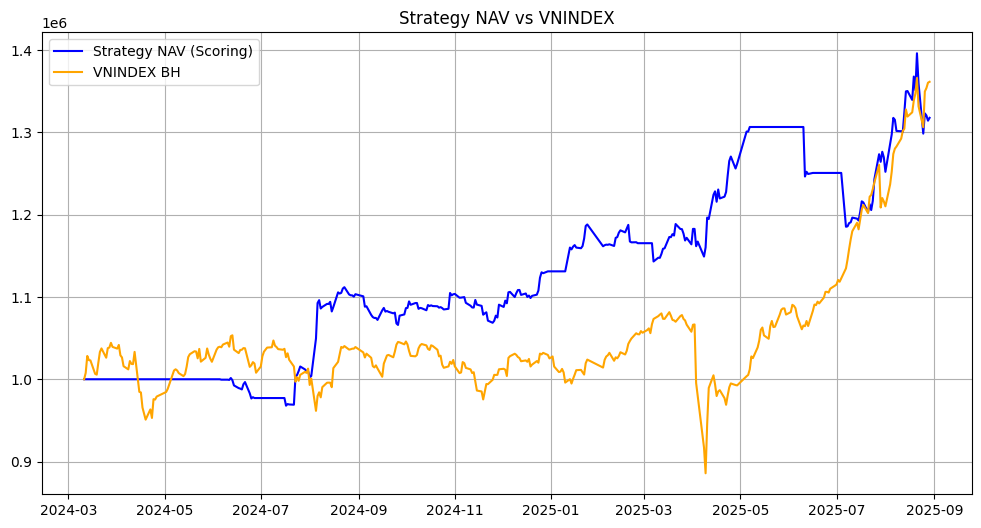

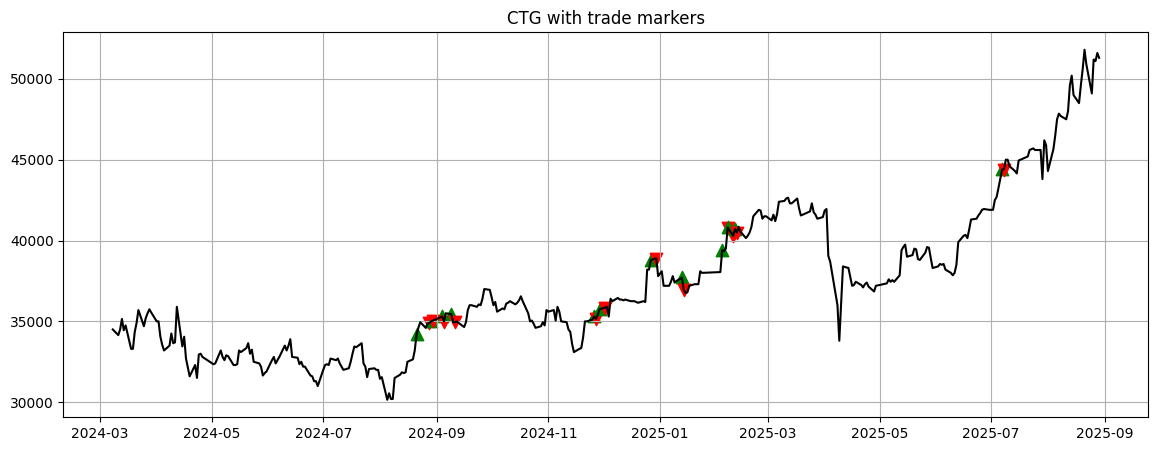

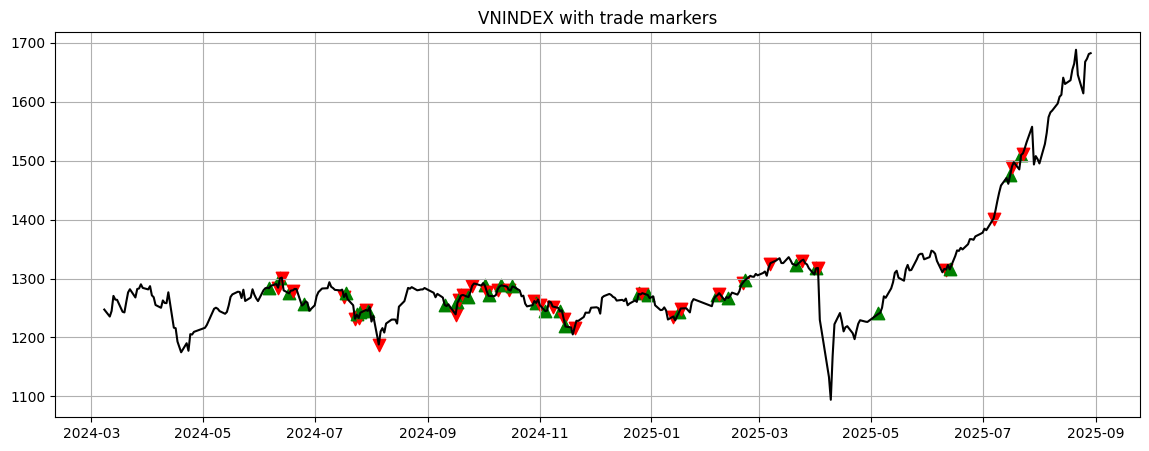

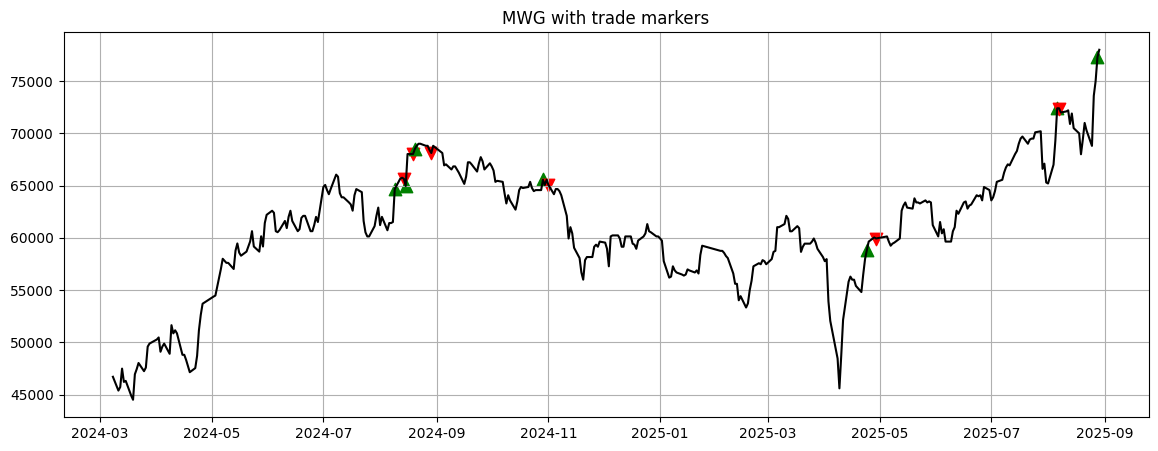

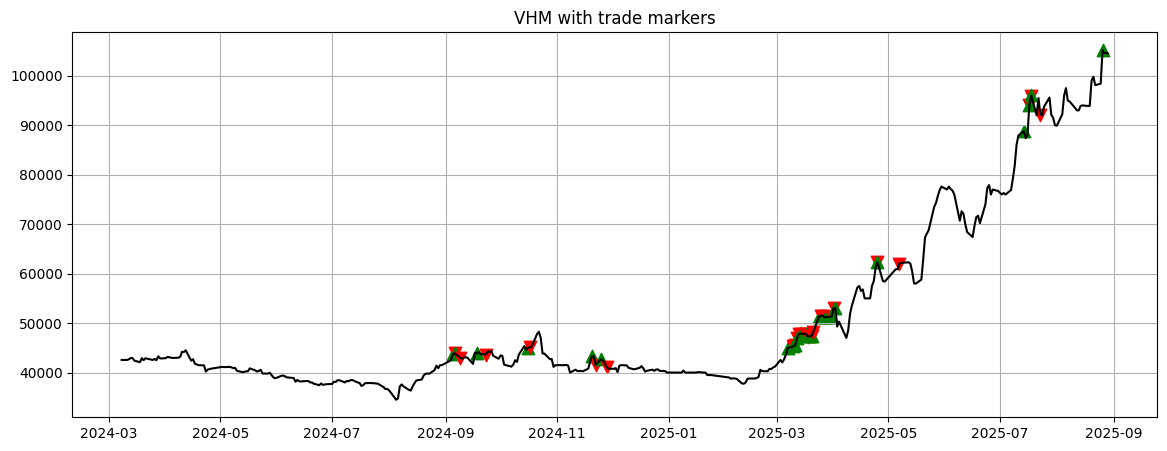

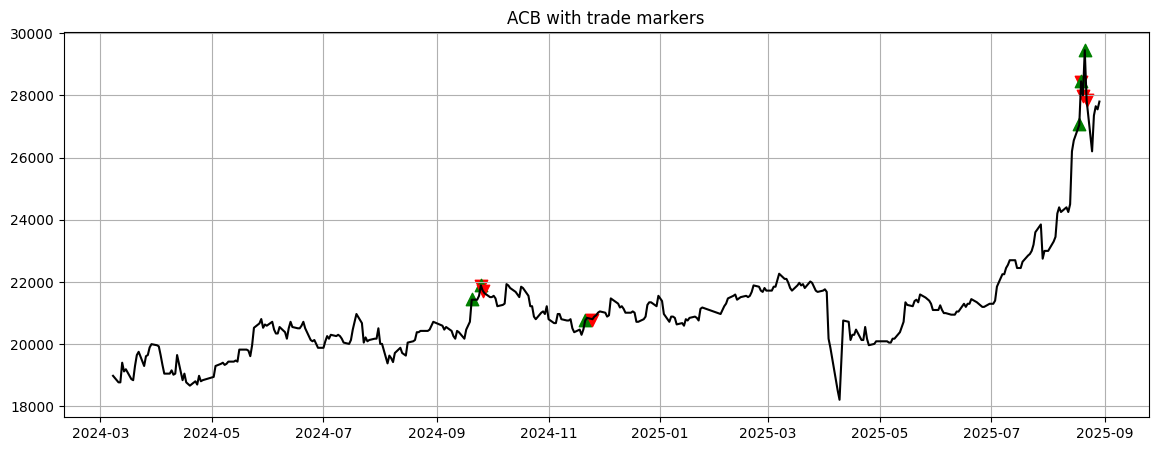

In [11]:
nav_df = pd.DataFrame(nav).set_index('date').sort_index()
nav_df['ret'] = nav_df['nav'].pct_change().fillna(0)

def compute_metrics(nav_df, trades):
    total_return = nav_df['nav'].iloc[-1] / nav_df['nav'].iloc[0] - 1
    days = (nav_df.index[-1] - nav_df.index[0]).days if len(nav_df)>1 else 1
    ann_ret = (1+total_return)**(365.0/days) - 1 if days>0 else np.nan
    ann_vol = nav_df['ret'].std() * np.sqrt(252) if len(nav_df)>1 else np.nan
    sharpe = ann_ret / ann_vol if ann_vol and ann_vol>0 else np.nan
    # pair trades
    pnls=[]
    i=0
    # collect entries and exits for same ticker
    entries = {}
    for tr in trades:
        if tr.get('type')=='entry' or tr.get('type')=='short':
            entries.setdefault(tr['ticker'], []).append(tr)
        if tr.get('type') in ('exit','short_exit'):
            # find last entry for this ticker
            ent_list = entries.get(tr['ticker'], [])
            if ent_list:
                ent = ent_list.pop(0)
                # compute pnl
                if ent.get('type')=='entry':
                    pnl = (tr['exit_price'] - ent['entry_price'])/ent['entry_price']
                else:
                    # short: ent type 'short' -> pnl = (entry - exit)/entry
                    pnl = (ent['entry_price'] - tr['exit_price'])/ent['entry_price']
                pnls.append(pnl)
    win_rate = np.mean([1 if p>0 else 0 for p in pnls]) if pnls else np.nan
    n_trades = len(pnls)
    roll_max = nav_df['nav'].cummax()
    drawdown = (nav_df['nav'] - roll_max) / roll_max
    max_dd = drawdown.min()
    return {'total_return':total_return,'ann_ret':ann_ret,'ann_vol':ann_vol,'sharpe':sharpe,'win_rate':win_rate,'n_trades':n_trades,'max_dd':max_dd,'pnls':pnls}

metrics = compute_metrics(nav_df, trades)
print("\n=== BACKTEST METRICS (SCORING TOP K) ===")
print(f"Period: {nav_df.index[0].date()} to {nav_df.index[-1].date()}")
print(f"Total return: {metrics['total_return']*100:.2f}%  Annualized: {metrics['ann_ret']*100:.2f}%  Sharpe: {metrics['sharpe']:.2f}")
print(f"Win rate: {metrics['win_rate']:.2%}  MaxDD: {metrics['max_dd']*100:.2f}%  #Trades: {metrics['n_trades']}")

# benchmark NAV
bench_daily = bench_series.reindex(nav_df.index).ffill().fillna(method='bfill')
bench_nav = (1 + bench_daily.pct_change().fillna(0)).cumprod() * INITIAL_CAPITAL
plt.figure(figsize=(12,6))
plt.plot(nav_df.index, nav_df['nav'], label='Strategy NAV (Scoring)', color='blue')
plt.plot(bench_nav.index, bench_nav.values, label='VNINDEX BH', color='orange')
plt.title('Strategy NAV vs VNINDEX')
plt.legend(); plt.grid(True); plt.show()

# Optional: plot trade markers for top performed tickers (show last year's markers)
def plot_trades_for_ticker(ticker, df_all, trades):
    series = df_all[df_all['ticker']==ticker].sort_values('date').set_index('date')
    if series.empty: 
        print("No data for", ticker); return
    plt.figure(figsize=(14,5))
    plt.plot(series.index, series['close'], label=ticker, color='black')
    for t in trades:
        if t.get('ticker')==ticker:
            if t.get('type') in ('entry','short'):
                plt.scatter(t.get('entry_date'), t.get('entry_price'), marker='^', color='green', s=80)
            if t.get('type') in ('exit','short_exit'):
                plt.scatter(t.get('exit_date'), t.get('exit_price'), marker='v', color='red', s=80)
    plt.title(f"{ticker} with trade markers"); plt.grid(True); plt.show()

# show few top tickers traded
traded_tickers = list({tr['ticker'] for tr in trades if 'ticker' in tr})
for t in traded_tickers[:5]:
    plot_trades_for_ticker(t, df, trades)
